In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from free_fermions import renyi_inf_entropy as rie
from scipy.optimize import curve_fit
from scipy.special import gamma

In [2]:
# Matplotlib settings
plt.rc("text", usetex=True)
plt.rc("text.latex", preamble=r"\usepackage{physics} \usepackage{mathtools}")
plt.rc("font", family="serif", size=16)
plt.rc("figure", figsize=(5, 4))

marker_options = dict(markersize=5, markeredgewidth=2)
text_options = dict(
    fontsize=14,
    horizontalalignment='right', 
    verticalalignment='center', 
   # bbox=dict(boxstyle="round", facecolor="white", alpha=0.5, edgecolor="grey")
)
legend_options = dict(
    title_fontsize=14, 
    fontsize=12, 
    handletextpad=0.5, 
    handlelength=1
)

In [3]:
# Fitting
def fit(fn, xdata, ydata):
    """Do a curve_fit and return the values and errors (instead of the covariance matrix)"""
    popt, pconv = curve_fit(fn, xdata, ydata)
    perr = np.sqrt(np.diag(pconv))
    return popt, perr

def print_fit_res(fit_res):
    for k, (param, err) in enumerate(zip(fit_res[0], fit_res[1])):
        print(f"    p{k} = {param} +- {err}")
    print()
 
fit_fn = lambda x, a, b, c: a*x + b*np.log(x) + c

## Case $\Delta = 0$ (free fermions)

In [4]:
# Lengths
half_lens = np.array(range(2, 26))
lens_even = np.array([2*N for N in half_lens])
lens_odd = np.array([2*N + 1 for N in half_lens])

In [5]:
# Min-Entropy
minent_XX_even = np.array([ rie(int(L), Np=L//2) for L in lens_even ])
minent_XX_odd  = np.array([ rie(int(L), Np=(L+1)//2) for L in lens_odd  ])

fit_results_even = fit(fit_fn, lens_even, minent_XX_even)
fit_results_odd  = fit(fit_fn, lens_odd,  minent_XX_odd )

print("Min-entropy fit results, even case:")
print_fit_res(fit_results_even)
print("Min-entropy fit results, odd case:")
print_fit_res(fit_results_odd)

Min-entropy fit results, even case:
    p0 = 0.34657358605595684 +- 4.707932424738332e-10
    p1 = 8.630411715949427e-08 +- 7.771174825701979e-09
    p2 = -1.584888689710628e-07 +- 1.6930681350453935e-08

Min-entropy fit results, odd case:
    p0 = 0.346368984025436 +- 2.8099583843030948e-05
    p1 = 0.25655152574935675 +- 0.0006128419323557234
    p2 = -0.21022232165070046 +- 0.001213950541843605



In [6]:
# Min-entropy difference fit
minent_XX_diff = minent_XX_odd - minent_XX_even
fit_diff_results = fit(fit_fn, lens_odd, minent_XX_diff)
print("Min-entropy difference fit:")
print_fit_res(fit_diff_results)

a, b, c = fit_diff_results[0]
fitted_fn = a*lens_odd + b * np.log(lens_odd) + c
#fitted_fn = 0.25 * np.log(lens_odd) + c

Min-entropy difference fit:
    p0 = -0.00020460601074024056 +- 2.8099582591123174e-05
    p1 = 0.2565515203023991 +- 0.0006128418090129857
    p2 = 0.1363512790889307 +- 0.0012139502727946897



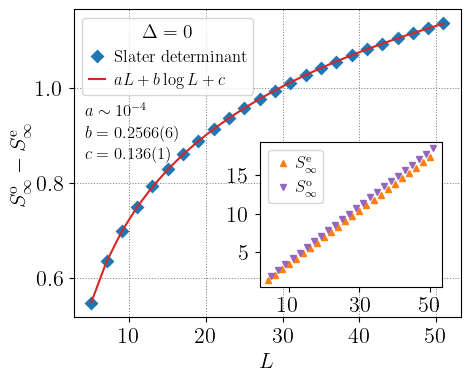

In [8]:
# Min-entropy difference

fig, ax = plt.subplots()
ax.plot(lens_odd, minent_XX_diff, "D", label="Slater determinant", color="tab:blue", **marker_options)
ax.plot(lens_odd, fitted_fn, "-", label=r"$a L + b \log L + c$", linewidth=1.5, color="tab:red")

ax.set_xlabel(r"$L$")
ax.set_ylabel(r"$S_{\infty}^{\text{o}} - S_{\infty}^{\text{e}}$")
ax.set_xticks(range(10,51,10))
ax.grid(color="gray", linestyle="dotted", linewidth=0.75)
ax.legend(loc="upper left", title=r"$\Delta = 0$", **legend_options)
#ax.text(0.5, 0.9, r"$\Delta = 0$", **text_options, transform=ax.transAxes)

text_options_0 = dict(
    fontsize=12,
    horizontalalignment='left', 
    verticalalignment='center', 
   # bbox=dict(boxstyle="round", facecolor="white", alpha=0.5, edgecolor="grey")
)
ax.text(0.03, 0.67, r"$a \sim 10^{-4}$", transform=ax.transAxes, **text_options_0)
ax.text(0.03, 0.6, r"$b = 0.2566(6)$", transform=ax.transAxes, **text_options_0)
ax.text(0.03, 0.53, r"$c = 0.136(1)$", transform=ax.transAxes, **text_options_0)

inset_ax = ax.inset_axes([0.48, 0.1, 0.47, 0.47])
inset_marker_opts = dict(markersize=4, markeredgewidth=1)
inset_ax.plot(lens_even, minent_XX_even, "^", label=r"$S_{\infty}^{\text{e}}$", color="tab:orange", **inset_marker_opts,)
inset_ax.plot(lens_odd,  minent_XX_odd,  "v", label=r"$S_{\infty}^{\text{o}}$", color="tab:purple", **inset_marker_opts, )
inset_ax.set_xticks([10, 30, 50])
#inset_ax.set_title(r"$\Delta = 0$")
#inset_ax.grid(color="gray", linestyle="dotted", linewidth=0.75)
inset_ax.legend(fontsize=12, handletextpad=0.2, handlelength=1)

fig.savefig("graphs/minent_delta_zero.pdf", bbox_inches="tight")

## Case $\Delta = 1/2$ (spin combinatorics)

In [15]:
# Data

minents_delta_half = pd.read_csv("data/max_probs_XXZ.csv")
minents_delta_half = minents_delta_half.loc[(minents_delta_half.delta == 0.5) & (minents_delta_half.L > 4), ["L", "minent"]]

In [18]:
# Analytical fit

def analytical_minent_delta_half(N):
    return (N-1)*np.log(3*np.sqrt(3)/4) + 2*np.log(np.sqrt(np.pi)/gamma(2/3)) + np.log(N/2)/3 # Stirling formula approximation

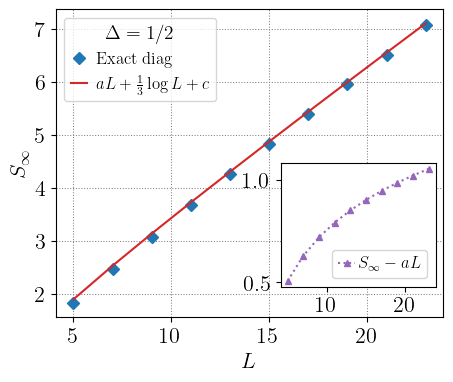

In [28]:
# Plot

fig, ax = plt.subplots()

minents_delta_half.plot("L", "minent", ax=ax, marker="D", label="Exact diag", linestyle='None')
ax.plot(
    minents_delta_half.L, 
    analytical_minent_delta_half(minents_delta_half.L), 
    "-", 
    label=r"$aL + \frac{1}{3} \log L + c$", 
    color="tab:red", 
    linewidth=1.5
)
ax.set_xlabel(r"$L$")
ax.set_ylabel(r"$S_{\infty}$")
ax.legend(title=r"$\Delta = 1/2$", **legend_options)
ax.grid(color="gray", linestyle="dotted", linewidth=0.75)


linear_term = np.log(3*np.sqrt(3)/4) * minents_delta_half.L
inset_ax = ax.inset_axes([0.58, 0.1, 0.40, 0.40])
inset_marker_opts = dict(markersize=5, markeredgewidth=1)
inset_ax.plot(
    minents_delta_half.L, 
    minents_delta_half.minent - linear_term, 
    ":^", 
    color="tab:purple", 
    label=r"$S_{\infty} - a L$", 
    **inset_marker_opts
)
inset_ax.legend(fontsize=12, handletextpad=0.2, handlelength=1)

fig.savefig("graphs/minent_delta_half.pdf", bbox_inches="tight")

## Whole critical region $\Delta \in (-1, 1]$

In [20]:
minents = pd.read_csv("data/max_probs_XXZ.csv")
minents

,L,delta,maxp,minent
0,3.0,-1.0,0.333333,1.098612
1,3.0,-0.9,0.333333,1.098612
2,3.0,-0.8,0.333333,1.098612
3,3.0,-0.7,0.333333,1.098612
4,3.0,-0.6,0.333333,1.098612
...,...,...,...,...
226,23.0,0.6,0.001107,6.806399
227,23.0,0.7,0.001429,6.550952
228,23.0,0.8,0.001826,6.305597
229,23.0,0.9,0.002310,6.070708


In [21]:
sizes  = minents.L.unique()
deltas = minents.delta.unique()

In [26]:
# Function wrapper for the fitting

def do_fit(df, fn=fit_fn, Lmin=6):
    f = pd.DataFrame(columns=("delta", "a", "b", "c", "a_err", "b_err", "c_err"))
    deltas = minents.delta.unique()
    for d in deltas:
        selection = df.loc[(df['delta'] == d) & (df['L'] >= Lmin), ['L', 'minent']]
        fit_results = fit(fn, selection.L, selection.minent)
        if len(fit_results[0]) == 2:
            f.loc[len(f)] = [d, *fit_results[0], 0, *fit_results[1], 0]
        else:
            f.loc[len(f)] = [d, *fit_results[0], *fit_results[1]]
    return f


In [27]:
# Fit minents against a L + b log L + c
fits = do_fit(minents, Lmin=6)

# Remove row corresponding to Delta = -1
fits = fits.drop(fits[fits['delta'] == -1].index)

fits

,delta,a,b,c,a_err,b_err,c_err
1,-0.9,0.580395,0.072753,-0.649202,0.000455,0.006219,0.009768
2,-0.8,0.537035,0.091372,-0.519228,0.000457,0.006238,0.009797
3,-0.7,0.503556,0.111052,-0.444517,0.000324,0.004428,0.006954
4,-0.6,0.474869,0.134019,-0.396399,0.000240,0.003276,0.005144
5,-0.5,0.449287,0.157314,-0.359873,0.000190,0.002593,0.004073
6,-0.4,0.425936,0.179714,-0.328413,0.000155,0.002123,0.003335
7,-0.3,0.404272,0.200905,-0.299030,0.000127,0.001736,0.002727
8,-0.2,0.383924,0.220934,-0.270234,0.000101,0.001378,0.002164
9,-0.1,0.364623,0.240013,-0.241272,0.000076,0.001033,0.001623
10,0.0,0.346161,0.258482,-0.211866,0.000052,0.000711,0.001117


In [30]:
# Theoretical curve

deltas = fits.delta
theor_y = np.linspace(0, 0.5, 50)
theor_x = - np.cos(2 * np.pi * theor_y)

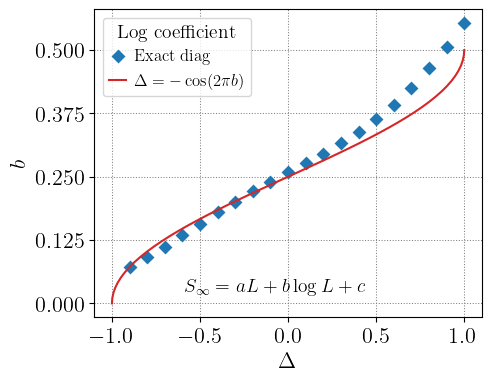

In [32]:
# Plot (without iMPS Ansatz)

fig, ax = plt.subplots()
ax.plot(fits.delta, fits.b, 'D', label="Exact diag", **marker_options)
#ax.errorbar(deltas, fits.b, fits.b_err, label="Exact diag")
ax.plot(theor_x, theor_y, "-", label=r"$\Delta = - \cos(2 \pi b)$", linewidth=1.5, color="tab:red")

ax.set_xlabel(r"$\Delta$")
ax.set_ylabel(r"$b$")
ax.set_yticks([0, 0.125, 0.25, 0.375, 0.5])
ax.legend(title="Log coefficient", **legend_options)
ax.grid(color="gray", linestyle="dotted", linewidth=0.75)
ax.text(0.70, 0.1, r"$S_{\infty} = a L + b \log L + c$", transform=ax.transAxes, **text_options)

fig.savefig("graphs/log_coefficient.pdf", bbox_inches="tight")

### Include the IMPS Ansatz

In [33]:
# Data

imps_minents = pd.read_csv("data/imps_minents.csv")
imps_minents

,delta,L,minent
0,-1.0,3.0,1.098612
1,-1.0,5.0,2.302585
2,-1.0,7.0,3.555348
3,-1.0,9.0,4.836282
4,-1.0,11.0,6.135565
...,...,...,...
226,1.0,15.0,4.218579
227,1.0,17.0,4.666552
228,1.0,19.0,5.107711
229,1.0,21.0,5.543419


In [35]:
# Fit

imps_fits = do_fit(imps_minents, Lmin=6)
imps_fits = imps_fits.drop(imps_fits[imps_fits['delta'] == -1].index)
imps_fits

,delta,a,b,c,a_err,b_err,c_err
1,-0.9,0.535803,0.019691,-0.539460,0.000115,0.001572,0.002469
2,-0.8,0.492776,0.083208,-0.474027,0.000043,0.000588,0.000924
3,-0.7,0.463174,0.121034,-0.422275,0.000005,0.000067,0.000105
4,-0.6,0.439779,0.149037,-0.379678,0.000018,0.000247,0.000387
5,-0.5,0.420024,0.172005,-0.343367,0.000032,0.000437,0.000686
6,-0.4,0.402662,0.192002,-0.311593,0.000041,0.000557,0.000875
7,-0.3,0.386984,0.210105,-0.283228,0.000046,0.000633,0.000995
8,-0.2,0.372536,0.226955,-0.257499,0.000050,0.000679,0.001067
9,-0.1,0.359006,0.242978,-0.233850,0.000051,0.000703,0.001104
10,0.0,0.346161,0.258482,-0.211866,0.000052,0.000711,0.001117


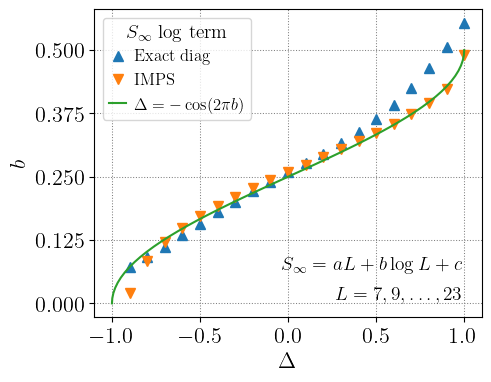

In [36]:
# Plot, including the iMPS Ansatz

fig, ax = plt.subplots()
marker_options = dict(markersize=7, markeredgewidth=1)

ax.plot(deltas, fits.b, '^', label="Exact diag", **marker_options)
ax.plot(imps_fits.delta, imps_fits.b, marker='v', linewidth=0, label='IMPS', **marker_options)
ax.plot(theor_x, theor_y, "-", label=r"$\Delta = - \cos(2 \pi b)$", linewidth=1.5)

ax.set_xlabel(r"$\Delta$")
ax.set_ylabel(r"$b$")
ax.set_yticks([0, 0.125, 0.25, 0.375, 0.5])
ax.legend(title=r"$S_{\infty}$ log term", **legend_options)
ax.grid(color="gray", linestyle="dotted", linewidth=0.75)
ax.text(0.95, 0.17, r"$S_{\infty} = a L + b \log L + c$", transform=ax.transAxes, **text_options)
ax.text(0.95, 0.075, r"$L=7,9, \dots, 23$", transform=ax.transAxes, **text_options)


fig.savefig("graphs/log_coefficient_with_imps.pdf", bbox_inches="tight")

In [32]:
Ls = minents_delta_half.L.unique()
linear_term = np.log(3*np.sqrt(3)/4) * Ls

linear_term

array([1.30812036, 1.8313685 , 2.35461665, 2.87786479, 3.40111293,
       3.92436108, 4.44760922, 4.97085737, 5.49410551, 6.01735365])

In [36]:
curve_fit(lambda x, a, b, c: a*x + b*np.log(x) + c, Ls, minents_delta_half.minent - linear_term)

(array([-0.00056211,  0.36538964, -0.07849386]),
 array([[ 2.61966283e-09, -3.10631541e-08,  4.21665299e-08],
        [-3.10631541e-08,  3.85226316e-07, -5.42863941e-07],
        [ 4.21665299e-08, -5.42863941e-07,  7.91308935e-07]]))

## Renyi Entropy scaling as function of the order $n$

Text(0.5, 0, 'Renyi order $n$')

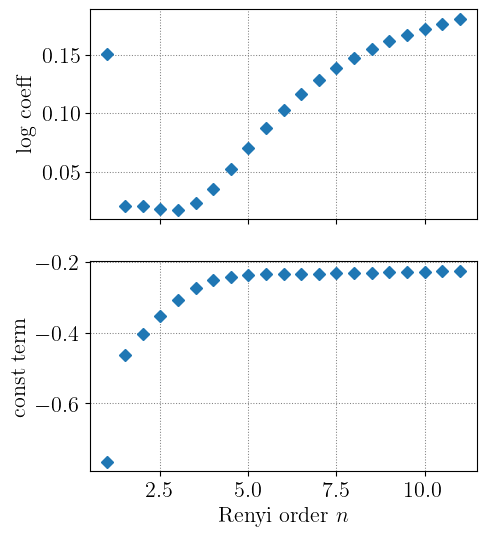

In [46]:
# Data

renyi_scaling = pd.read_csv("data/renyi_scaling_odd.csv")

fig, axs = plt.subplots(2, 1, sharex=True, figsize=(5, 6))

axs[0].plot(renyi_scaling.renyi_order, renyi_scaling.log_coeff, marker='D', linestyle='None')
axs[0].grid(color="gray", linestyle="dotted", linewidth=0.75)
axs[0].set_ylabel("log coeff")

axs[1].plot(renyi_scaling.renyi_order, renyi_scaling.const_coeff, marker='D', linestyle='None')
axs[1].grid(color="gray", linestyle="dotted", linewidth=0.75)
axs[1].set_ylabel("const term")
axs[1].set_xlabel("Renyi order $n$")

## IMPS Norm ratios

Text(0, 0.5, '$Z_{odd}(N) / Z_{even}(N)$')

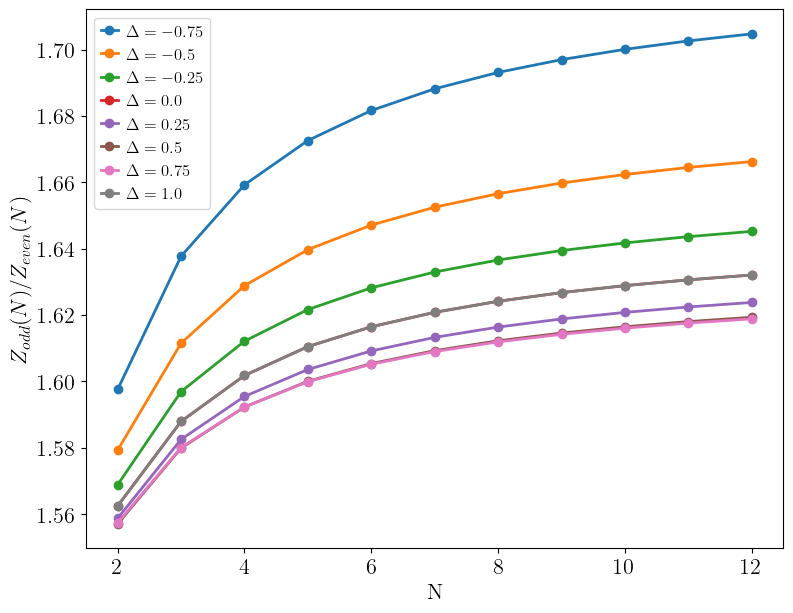

In [13]:
data = pd.read_csv("imps_ratio.csv")

plt.figure(figsize=(9, 7))
deltas = data.delta.unique()
for d in deltas:
    select = data.loc[data.delta == d]
    plt.plot(select.N, select.ratio, "-o", label=f"$\\Delta = {d}$", linewidth=2)

plt.legend(**legend_options)
plt.xlabel("N")
plt.ylabel("$Z_{odd}(N) / Z_{even}(N)$")